# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time

## Uploading data from file

In [2]:
DATA_PATH = "../../../data/4_best_predictions/"
FILE_PATTERN = "pa_transformer_predictions_{0}.csv"

In [3]:
valid = pd.read_csv(DATA_PATH + FILE_PATTERN.format('valid'))
test = pd.read_csv(DATA_PATH + FILE_PATTERN.format('test'))

In [4]:
compare_data = pd.DataFrame({'smiles': test.smiles, 'y_expected': test.logp, 'y_predicted': test.logp_pred})

In [5]:
X_valid_mol = [Chem.MolFromSmiles(x) for x in valid.smiles]
X_test_mol = [Chem.MolFromSmiles(x) for x in test.smiles]

In [6]:
y_test = test.logp
y_valid = valid.logp

## Getting the data to compare

In [7]:
compare_data.head()

,smiles,y_expected,y_predicted
0,CC(=O)NC(Cc1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)N(C)...,2.63,2.410858
1,CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2...,4.17,4.165854
2,CCS(=O)c1sc(C(C)=O)c(N)c1C#N,1.82,1.935241
3,O=P(Oc1ccccc1)(Oc1ccccc1)Oc1ccccc1,4.59,3.957006
4,OC1(c2cc(Cl)ccc2Cl)CCCCC1n1cncn1,3.24,3.147647


In [8]:
compare_data.shape

(2067, 3)

In [9]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [10]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,8.933699,47.247738
1730,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-3.280066,12.960475
1727,O=S(=O)(O)c1cc(N=c2[nH]c(N3CCOCC3)nc(=Nc3ccccc...,1.48,4.638897,9.978630
658,CC1OC(OC2C(O)CC(OC3C(O)CC(OC4CCC5(C)C(CCC6C5CC...,-1.77,1.197967,8.808826
1824,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,2.483271,7.253707


In [11]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
1255,COc1ncnc2c1ncn2C1OC(CO)C(OC(=O)Cc2ccccc2)C1OC(...,3.48,3.480126,1.580049e-08
1681,O=S1(=O)Nc2ccccc2N1,1.12,1.119755,5.987809e-08
758,CC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(C(N)=O)C(C)C,0.73,0.729388,3.742503e-07
1050,CCNC(=O)NS(=O)(=O)c1ccccc1,0.90,0.900748,5.589955e-07
1876,CC(=O)OCN1C(=O)C=C(C)C1=O,0.45,0.451109,1.228772e-06


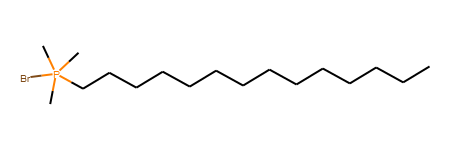

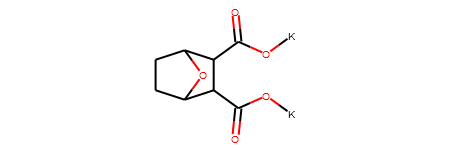

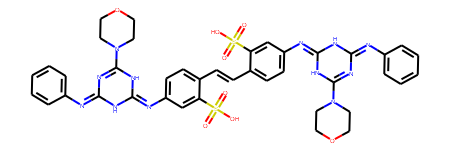

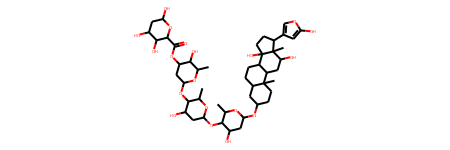

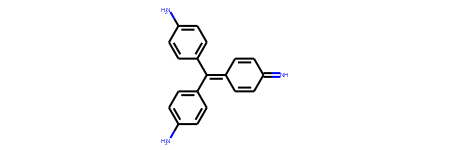

In [12]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

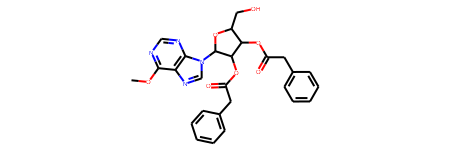

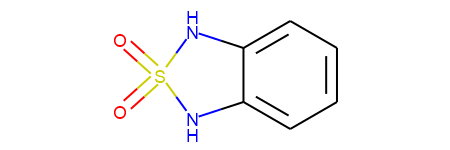

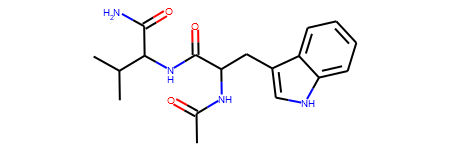

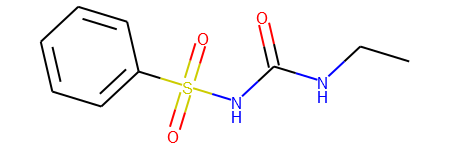

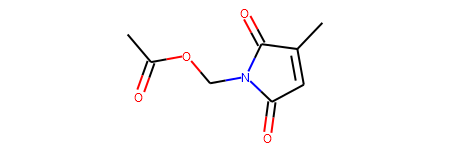

In [13]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [14]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings
- The count and percent of aromatic bonds
- The symmetry of molecules

In [15]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

## Analyzing the data features

In [16]:
compare_data_with_stats = create_statistics(compare_data)

In [17]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1255,COc1ncnc2c1ncn2C1OC(CO)C(OC(=O)Cc2ccccc2)C1OC(...,3.48,3.480126,1.580049e-08,18,1,2,11.111111,1,100.0,42,22,52.380952,False
1681,O=S1(=O)Nc2ccccc2N1,1.12,1.119755,5.987809e-08,12,2,0,0.000000,2,100.0,12,6,50.000000,True
758,CC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(C(N)=O)C(C)C,0.73,0.729388,3.742503e-07,15,5,0,0.000000,0,0.0,26,10,38.461538,False
1050,CCNC(=O)NS(=O)(=O)c1ccccc1,0.90,0.900748,5.589955e-07,24,2,0,0.000000,2,100.0,15,6,40.000000,False
1876,CC(=O)OCN1C(=O)C=C(C)C1=O,0.45,0.451109,1.228772e-06,10,1,2,20.000000,1,100.0,13,0,0.000000,False


#### Splitting data into 3 parts

In [18]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [19]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.285800,2.285878,5.155709e-03,17.648177,1.820919,0.870048,5.349776,0.974643,54.752094,16.660856,7.410460,45.727717
std,1.691138,1.682570,4.845916e-03,7.964594,1.197062,1.451515,9.705430,0.796415,40.725484,7.140475,4.395649,23.309224
min,-2.280000,-2.221065,1.580049e-08,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.230000,1.239923,8.485037e-04,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,33.333333
50%,2.190000,2.190436,3.670603e-03,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,15.000000,6.000000,46.153846
75%,3.185000,3.219027,8.443944e-03,21.000000,2.000000,1.000000,7.692308,1.000000,100.000000,19.500000,11.000000,60.000000
max,8.200000,8.206756,1.604590e-02,62.000000,8.000000,10.000000,100.000000,5.000000,100.000000,62.000000,27.000000,100.000000


In [20]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.00000,631.000000,631.000000,631.000000,631.000000
mean,2.248938,2.269639,0.044170,17.478605,1.811410,0.849445,5.248863,0.92393,54.689080,18.309033,7.489699,42.511914
std,1.727263,1.717319,0.020934,7.147589,1.214043,1.309730,8.393454,0.72850,41.290791,8.670396,4.636584,24.193138
min,-2.780000,-3.005611,0.016120,5.000000,0.000000,0.000000,0.000000,0.00000,0.000000,4.000000,0.000000,0.000000
25%,1.170000,1.243981,0.025961,13.000000,1.000000,0.000000,0.000000,0.00000,0.000000,13.000000,6.000000,29.411765
50%,2.120000,2.189240,0.040499,17.000000,2.000000,0.000000,0.000000,1.00000,50.000000,17.000000,6.000000,45.833333
75%,3.305000,3.240006,0.060112,21.000000,2.000000,1.000000,7.692308,1.00000,100.000000,22.000000,11.000000,60.000000
max,8.560000,8.735890,0.090891,65.000000,8.000000,8.000000,66.666667,4.00000,100.000000,85.000000,26.000000,100.000000


In [21]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,2.073703,2.165769,0.236603,17.816456,1.731013,0.903481,5.551530,0.919304,55.633288,19.219937,7.977848,42.016288
std,1.935662,1.880260,0.124629,8.084607,1.175740,1.364662,8.780761,0.745706,42.144497,8.774732,5.255393,23.476065
min,-3.400000,-3.952872,0.090900,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.677500,0.840974,0.133619,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.000000,6.000000,28.571429
50%,1.980000,2.133472,0.197564,16.500000,1.000000,0.000000,0.000000,1.000000,50.000000,18.000000,6.000000,42.857143
75%,3.332500,3.361694,0.316576,21.000000,2.000000,1.000000,7.692308,1.000000,100.000000,23.000000,12.000000,57.142857
max,8.600000,8.435294,0.563222,85.000000,9.000000,9.000000,80.000000,5.000000,100.000000,59.000000,30.000000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [22]:
best = data[0].reset_index().drop(columns=['index'])

In [23]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,COc1ncnc2c1ncn2C1OC(CO)C(OC(=O)Cc2ccccc2)C1OC(...,3.48,3.480126,1.580049e-08,18,1,2,11.111111,1,100.0,42,22,52.380952,False
1,O=S1(=O)Nc2ccccc2N1,1.12,1.119755,5.987809e-08,12,2,0,0.000000,2,100.0,12,6,50.000000,True
2,CC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(C(N)=O)C(C)C,0.73,0.729388,3.742503e-07,15,5,0,0.000000,0,0.0,26,10,38.461538,False
3,CCNC(=O)NS(=O)(=O)c1ccccc1,0.90,0.900748,5.589955e-07,24,2,0,0.000000,2,100.0,15,6,40.000000,False
4,CC(=O)OCN1C(=O)C=C(C)C1=O,0.45,0.451109,1.228772e-06,10,1,2,20.000000,1,100.0,13,0,0.000000,False


In [24]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=10))

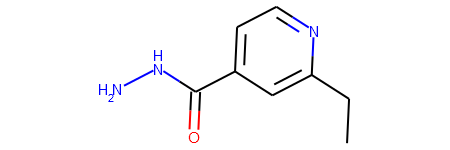

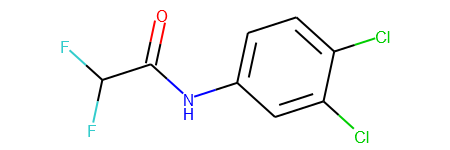

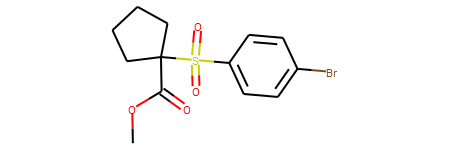

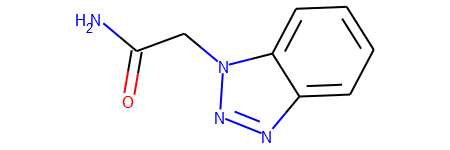

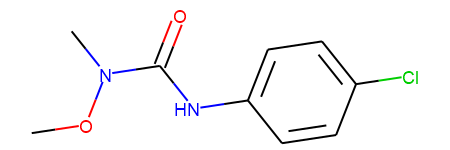

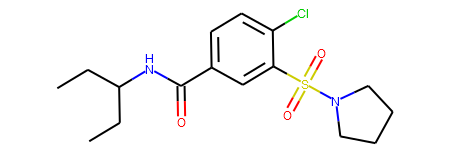

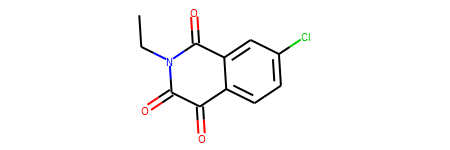

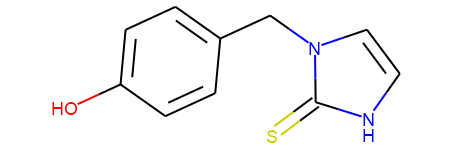

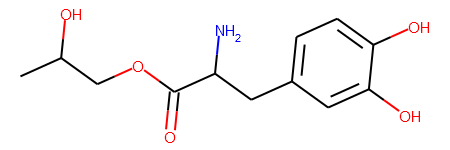

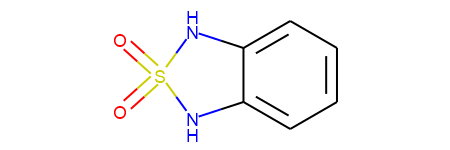

In [25]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [26]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [27]:
middle = data[1].reset_index().drop(columns=['index'])

In [28]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,Oc1ccc(Cl)c(Cl)c1Cl,3.80,3.673035,0.016120,29,4,3,10.344828,0,0.0,10,6,60.000000,False
1,Cc1ccc2cc(C)ccc2c1,4.31,4.437232,0.016188,13,0,0,0.000000,0,0.0,13,11,84.615385,True
2,COC(=O)c1ccccc1C,2.75,2.622513,0.016253,21,1,1,4.761905,1,100.0,11,6,54.545455,False
3,O=C(Oc1ccccc1)c1ccccc1,3.59,3.462463,0.016266,15,2,2,13.333333,0,0.0,16,12,75.000000,False
4,O=C(NC(CO)C(O)c1ccc(Cl)cc1)C(Cl)Cl,1.64,1.767690,0.016305,24,0,0,0.000000,0,0.0,18,6,33.333333,False


In [29]:
middle.shape

(631, 14)

In [30]:
indices = pd.Series(np.random.randint(631, size=10))

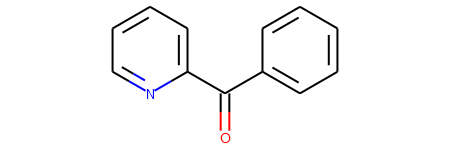

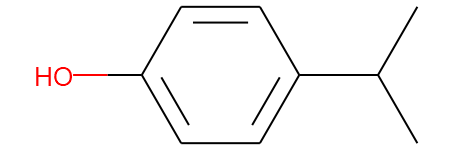

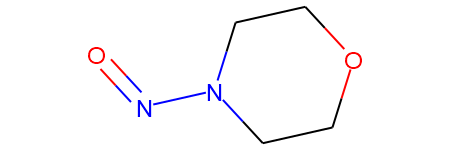

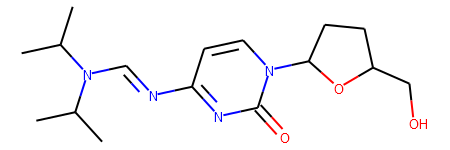

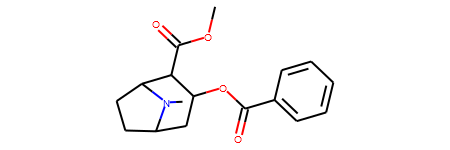

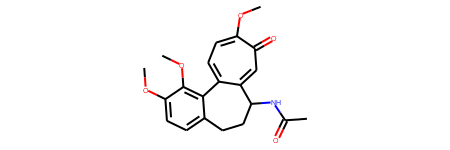

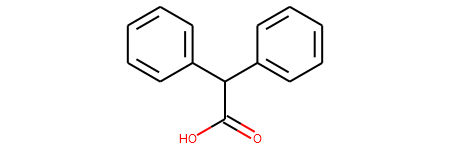

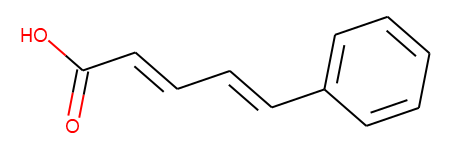

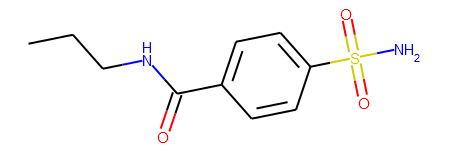

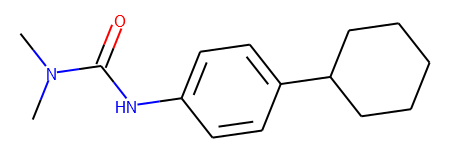

In [31]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [32]:
worst = data[2].reset_index().drop(columns=['index'])

In [33]:
indices = pd.Series(np.random.randint(631, size=10))

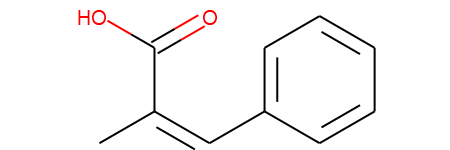

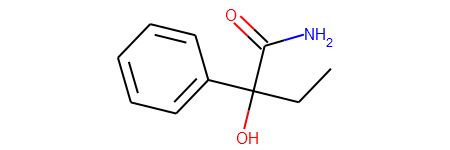

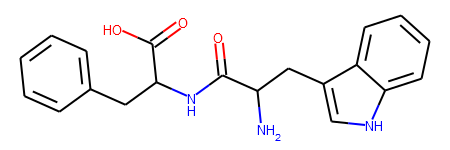

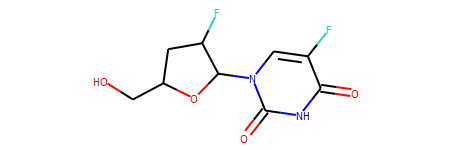

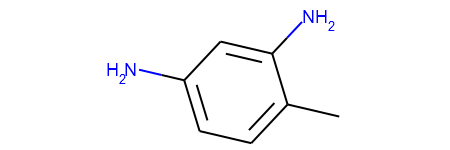

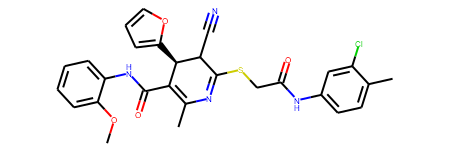

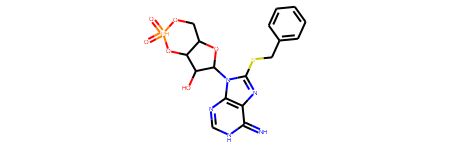

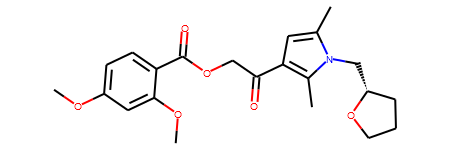

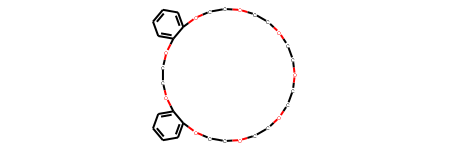

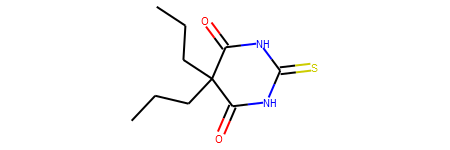

In [34]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [35]:
n_values = 200

In [36]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [37]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [38]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1255,COc1ncnc2c1ncn2C1OC(CO)C(OC(=O)Cc2ccccc2)C1OC(...,3.48,3.480126,1.580049e-08,18,1,2,11.111111,1,100.0,42,22,52.380952,False
1681,O=S1(=O)Nc2ccccc2N1,1.12,1.119755,5.987809e-08,12,2,0,0.000000,2,100.0,12,6,50.000000,True
758,CC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(C(N)=O)C(C)C,0.73,0.729388,3.742503e-07,15,5,0,0.000000,0,0.0,26,10,38.461538,False
1050,CCNC(=O)NS(=O)(=O)c1ccccc1,0.90,0.900748,5.589955e-07,24,2,0,0.000000,2,100.0,15,6,40.000000,False
1876,CC(=O)OCN1C(=O)C=C(C)C1=O,0.45,0.451109,1.228772e-06,10,1,2,20.000000,1,100.0,13,0,0.000000,False


In [39]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,8.933699,47.247738,43,5,0,0.000000,3,60.0,18,0,0.000000,False
1730,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-3.280066,12.960475,12,1,0,0.000000,1,100.0,16,0,0.000000,True
1727,O=S(=O)(O)c1cc(N=c2[nH]c(N3CCOCC3)nc(=Nc3ccccc...,1.48,4.638897,9.978630,17,2,0,0.000000,1,50.0,69,36,52.173913,True
658,CC1OC(OC2C(O)CC(OC3C(O)CC(OC4CCC5(C)C(CCC6C5CC...,-1.77,1.197967,8.808826,28,4,4,14.285714,1,25.0,74,5,6.756757,False
1824,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,2.483271,7.253707,15,2,0,0.000000,1,50.0,24,12,50.000000,False


In [40]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,2.000000e+02,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.185900,2.182931,4.512525e-04,17.615000,1.860000,0.90500,5.686347,0.980000,54.404762,16.940000,7.260000,45.042319
std,1.666601,1.664122,3.980111e-04,8.676009,1.303416,1.58383,11.160273,0.820344,41.226019,7.820627,4.041543,22.447773
min,-2.030000,-2.013083,1.580049e-08,5.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.260000,1.247900,1.091923e-04,12.000000,1.000000,0.00000,0.000000,0.000000,0.000000,12.000000,6.000000,35.294118
50%,2.110000,2.114713,3.269859e-04,16.000000,2.000000,0.00000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,3.102500,3.091646,7.440839e-04,21.000000,2.000000,1.00000,8.333333,1.000000,100.000000,19.250000,10.250000,60.000000
max,8.200000,8.164659,1.305984e-03,62.000000,8.000000,10.00000,100.000000,4.000000,100.000000,62.000000,22.000000,100.000000


In [41]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.846550,1.996773,1.601298,17.730000,1.700000,0.705000,4.674492,0.910000,54.500000,22.115000,8.595000,38.447328
std,2.268083,2.240179,3.615208,8.993973,1.107308,1.088069,7.897540,0.758138,41.748496,10.545988,6.882428,24.708342
min,-3.700000,-4.451451,0.499293,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.350000,0.336569,0.623354,12.750000,1.000000,0.000000,0.000000,0.000000,0.000000,15.000000,6.000000,23.769231
50%,1.775000,1.872226,0.886138,15.500000,1.000000,0.000000,0.000000,1.000000,50.000000,21.000000,6.000000,40.370370
75%,3.400000,3.629571,1.355207,20.250000,2.000000,1.000000,6.666667,1.000000,100.000000,26.000000,12.000000,55.313737
max,7.550000,8.933699,47.247738,85.000000,6.000000,5.000000,50.000000,4.000000,100.000000,74.000000,36.000000,100.000000


### Check atom_count influence

In [42]:
print(stats.kruskal(best_n_vals.atom_count, worst_n_vals.atom_count))

KruskalResult(statistic=0.014919429630612062, pvalue=0.9027840910837842)


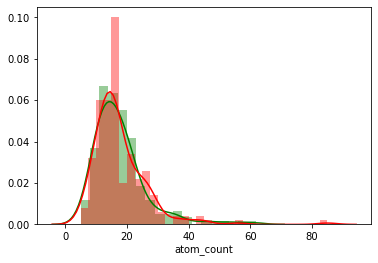

In [43]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [44]:
print(stats.kruskal(best_n_vals.ring_count, worst_n_vals.ring_count))

KruskalResult(statistic=1.1203549096782766, pvalue=0.2898420455516732)


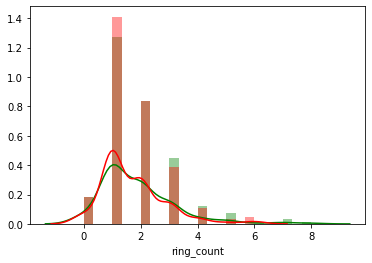

In [45]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [46]:
print(stats.kruskal(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

KruskalResult(statistic=0.4099517554417967, pvalue=0.5219939934005874)


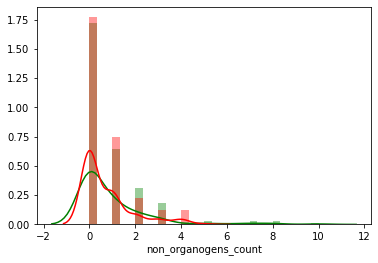

In [47]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [48]:
print(stats.kruskal(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

KruskalResult(statistic=0.3789929933922033, pvalue=0.5381426625133073)


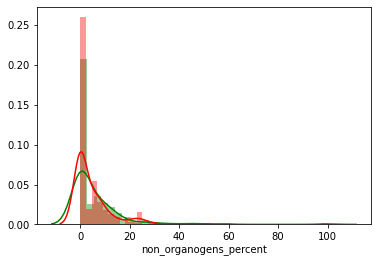

In [49]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [50]:
print(stats.kruskal(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

KruskalResult(statistic=0.5280619244526261, pvalue=0.46742280821639015)


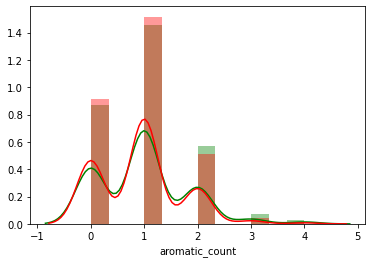

In [51]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [52]:
print(stats.kruskal(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

KruskalResult(statistic=0.001407533456212765, pvalue=0.9700726988628519)


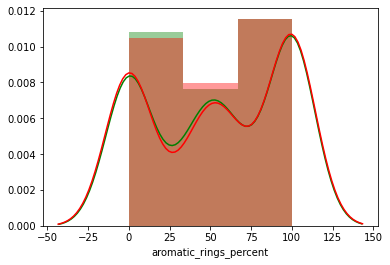

In [53]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [54]:
print(stats.kruskal(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

KruskalResult(statistic=8.18556380781056, pvalue=0.004222505315985969)


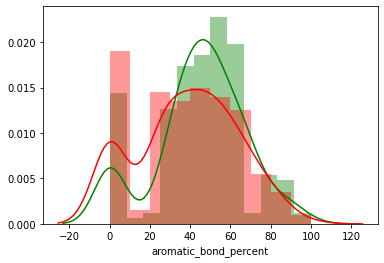

In [55]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [56]:
print(stats.kruskal(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

KruskalResult(statistic=2.136584111748912, pvalue=0.14382182224319043)


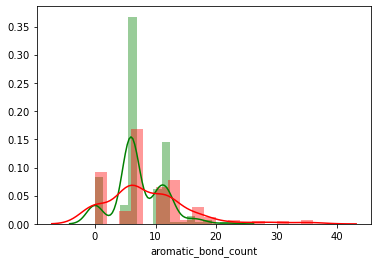

In [57]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

### Check symmetric count

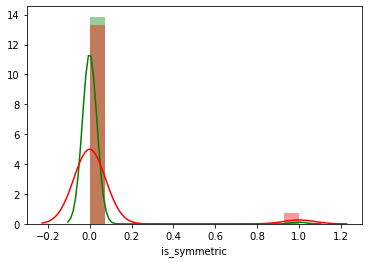

In [58]:
sns.distplot(best_n_vals.is_symmetric, color='g')
sns.distplot(worst_n_vals.is_symmetric, color='r')

### Metrics analysis among symmetric and not symmetric molecules

In [59]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [60]:
X_test_mol = [Chem.MolFromSmiles(x) for x in compare_data.smiles]

In [61]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in X_test_mol]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [62]:
symmetric_y_predicted = compare_data.y_predicted[symmetric_indices]

In [63]:
symmetric_y_expected = compare_data.y_expected[symmetric_indices]

In [64]:
not_symmetric_y_predicted = compare_data.y_predicted[not_symmetric_indices]

In [65]:
not_symmetric_y_expected = compare_data.y_expected[not_symmetric_indices]

In [66]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 0.8089064990089876
Test symmetric R2-score is 0.8764863445600731


In [67]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.4696028389807185
Test not symmetric R2-score is 0.9325118250639969
